In [720]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error
from geopy.distance import great_circle
from category_encoders import LeaveOneOutEncoder

# Загрузка данных
data = pd.read_csv('train.csv')


In [722]:
# Определение выбросов для trip_duration
Q1 = data['trip_duration'].quantile(0.25)
Q3 = data['trip_duration'].quantile(0.75)
IQR = Q3 - Q1

# Фильтрация выбросов
data = data[(data['trip_duration'] >= (Q1 - 1.5 * IQR)) & (data['trip_duration'] <= (Q3 + 1.5 * IQR))]

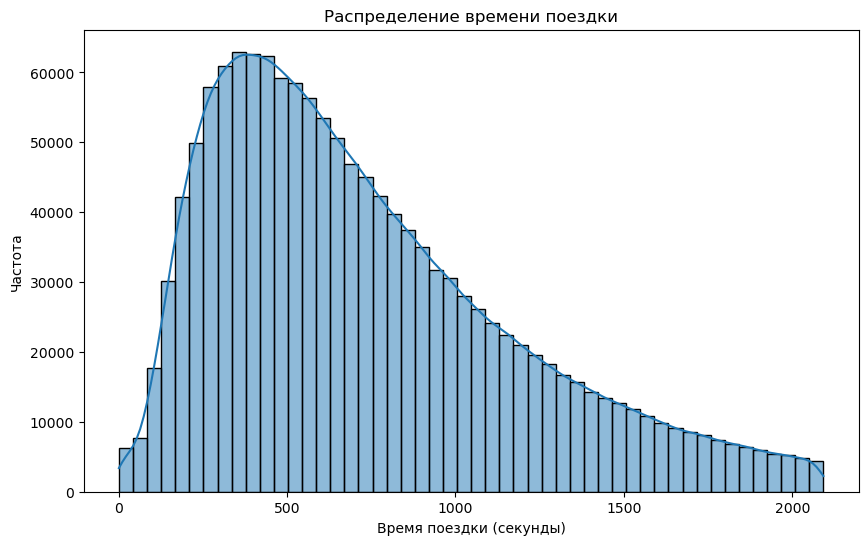

In [702]:
plt.figure(figsize=(10, 6))
sns.histplot(data['trip_duration'], bins=50, kde=True)
plt.title('Распределение времени поездки')
plt.xlabel('Время поездки (секунды)')
plt.ylabel('Частота')
plt.show()

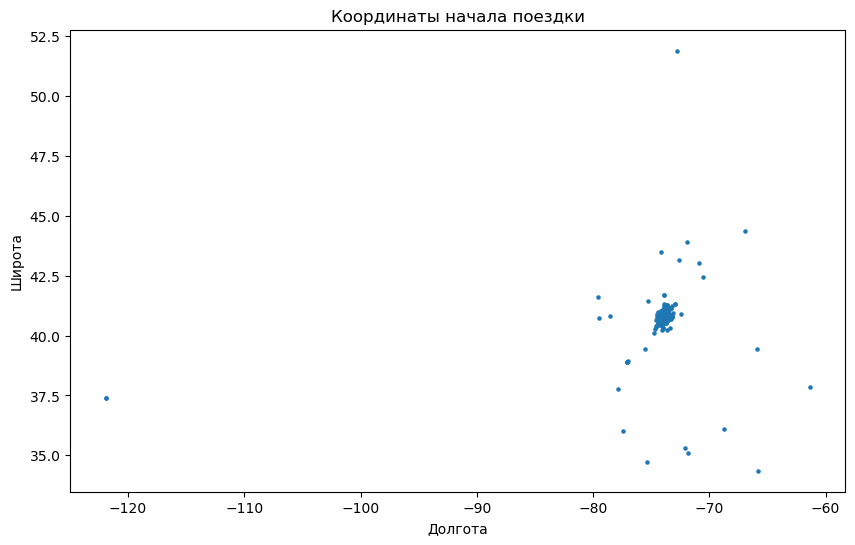

In [705]:
plt.figure(figsize=(10, 6))
plt.scatter(data['pickup_longitude'], data['pickup_latitude'], alpha=1, s=5)
plt.title('Координаты начала поездки')
plt.xlabel('Долгота')
plt.ylabel('Широта')
plt.show()

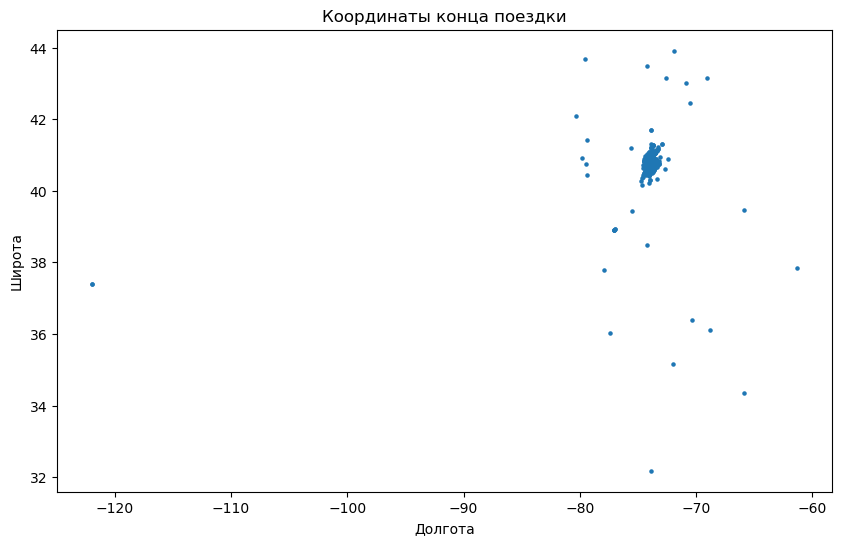

In [710]:
plt.figure(figsize=(10, 6))
plt.scatter(data['dropoff_longitude'], data['dropoff_latitude'], alpha=1, s=5)
plt.title('Координаты конца поездки')
plt.xlabel('Долгота')
plt.ylabel('Широта')
plt.show()

In [724]:
# Преобразование временных меток
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['dropoff_datetime'] = pd.to_datetime(data['dropoff_datetime'])

data['pickup_hour'] = data['pickup_datetime'].dt.hour
data['pickup_day'] = data['pickup_datetime'].dt.dayofweek
data['pickup_month'] = data['pickup_datetime'].dt.month
data['pickup_year'] = data['pickup_datetime'].dt.year
data['pickup_is_weekend'] = data['pickup_day'].apply(lambda x: 1 if x >= 5 else 0)

data['trip_duration'] = (data['dropoff_datetime'] - data['pickup_datetime']).dt.total_seconds()

# Удаление ненужных столбцов
data.drop(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count'], axis=1, inplace=True)


In [725]:
data['distance'] = data.apply(lambda row: great_circle((row['pickup_latitude'], row['pickup_longitude']),
                                                         (row['dropoff_latitude'], row['dropoff_longitude'])).meters, axis=1)
data.drop(['pickup_latitude', 'dropoff_latitude', 'pickup_longitude', 'dropoff_longitude'], axis=1)


,store_and_fwd_flag,trip_duration,pickup_hour,pickup_day,pickup_month,pickup_year,pickup_is_weekend,distance
0,N,455.0,17,0,3,2016,0,1498.522897
1,N,663.0,0,6,6,2016,1,1805.509719
3,N,429.0,19,2,4,2016,0,1485.500521
4,N,435.0,13,5,3,2016,1,1188.590138
5,N,443.0,22,5,1,2016,1,1098.944012
...,...,...,...,...,...,...,...,...
1458639,N,778.0,13,4,4,2016,0,1225.081841
1458640,N,655.0,7,6,1,2016,1,6049.844126
1458641,N,764.0,6,4,4,2016,0,7824.616829
1458642,N,373.0,15,1,1,2016,0,1092.565435


In [727]:
data.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour,pickup_day,pickup_month,pickup_year,pickup_is_weekend,distance
0,-73.982155,40.767937,-73.964630,40.765602,N,455.0,17,0,3,2016,0,1498.522897
1,-73.980415,40.738564,-73.999481,40.731152,N,663.0,0,6,6,2016,1,1805.509719
3,-74.010040,40.719971,-74.012268,40.706718,N,429.0,19,2,4,2016,0,1485.500521
4,-73.973053,40.793209,-73.972923,40.782520,N,435.0,13,5,3,2016,1,1188.590138
5,-73.982857,40.742195,-73.992081,40.749184,N,443.0,22,5,1,2016,1,1098.944012


# Регуляризация и обучение модели

### Ridge

In [730]:
# Определение признаков и целевой переменной
X = data.drop('trip_duration', axis=1)
y = data['trip_duration']

# Кодирование категориальных переменных
X = pd.get_dummies(X, columns=['store_and_fwd_flag'], drop_first=True)

# Масштабирование
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [731]:
model = Ridge(alpha=1.0)
model.fit(X_train, y_train)

# Предсказание
y_pred = model.predict(X_test)

# Оценка модели
rmse_1 = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse_1}')


RMSE: 351.43579093589574


### Кодирование категориальных переменных с Lasso

In [735]:
from category_encoders import LeaveOneOutEncoder

In [737]:
encoder = LeaveOneOutEncoder()

In [739]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [741]:
X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.transform(X_test)

In [743]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [745]:
ridge = Lasso()
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

In [747]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

346.6223333186649

### Линейная регрессия

In [750]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

346.7875617370825

### Аналитическое решение

In [753]:
from LinearModelAnalytics import Lin_reg_analytic

analytic = Lin_reg_analytic()
analytic.fit(X_train, y_train)

In [755]:
y_pred = analytic.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

346.78756173708183

### Градиентный спуск

In [758]:
from LinearModel import LinearReg

model = LinearReg()
model.fit(X_train, y_train)

In [759]:
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

809.2127787099762

### SGD

In [761]:
from LinearModelSGD import Lin_reg_sgd

model = Lin_reg_sgd(lr=0.1)
model.fit(X_train, y_train.to_numpy())

In [762]:
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

450.4284437242309

### Регуляризация (Lasso)

In [768]:
lasso = Lasso()
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

346.6223333186649

### Кросс-Валидация

In [771]:
from sklearn.model_selection import KFold

In [773]:
kf = KFold(n_splits=5)

errors = []
models = []

for train_i, test_i in kf.split(X_train):
    X_train_fold, X_test_fold = X_train[train_i], X_train[test_i]
    y_train_fold, y_test_fold = y_train.to_numpy()[train_i], y_train.to_numpy()[test_i]

    model = Lasso()
    model.fit(X_train_fold, y_train_fold)
    models.append(model)
    errors.append(np.sqrt(mean_squared_error(y_test_fold, model.predict(X_test_fold))))
    

In [775]:
preds = []
for model in models:
    preds.append(model.predict(X_test))

pred = np.mean(preds, axis=0)

In [779]:
np.mean(errors)

371.22349328751403

### Гиперпараметрическая оптимизация

In [628]:
alphas = np.linspace(0.1, 10, 100)
param_grid = {
    'alpha': alphas
}

In [630]:
grid_search = GridSearchCV(Lasso(random_state=42), param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=Lasso(random_state=42),
             param_grid={'alpha': array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
        1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,
        2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,  3.3,
        3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,  4.4,
        4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,  5.5,
        5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,  6.6,
        6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,  7.7,
        7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,  8.8,
        8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,  9.9,
       10. ])},
             scoring='neg_mean_squared_error')

In [631]:
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
best_rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))
print(f'Best RMSE after Grid Search with Lasso: {best_rmse}')

Best RMSE after Grid Search with Lasso: 345.86951914807645


In [632]:
data.head()

,store_and_fwd_flag,trip_duration,pickup_hour,pickup_day,pickup_month,pickup_year,pickup_is_weekend,distance
0,N,455.0,17,0,3,2016,0,1498.522897
1,N,663.0,0,6,6,2016,1,1805.509719
3,N,429.0,19,2,4,2016,0,1485.500521
4,N,435.0,13,5,3,2016,1,1188.590138
5,N,443.0,22,5,1,2016,1,1098.944012


# Используем манхетенское расстояние

In [792]:
data = pd.read_csv('train.csv')

Q1 = data['trip_duration'].quantile(0.25)
Q3 = data['trip_duration'].quantile(0.75)
IQR = Q3 - Q1

# Фильтрация выбросов
data = data[(data['trip_duration'] >= (Q1 - 1.5 * IQR)) & (data['trip_duration'] <= (Q3 + 1.5 * IQR))]

# Преобразование временных меток
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['dropoff_datetime'] = pd.to_datetime(data['dropoff_datetime'])

def create_grid(lat, lon):
    lat_bins = np.linspace(40.5, 40.9, 4)
    lon_bins = np.linspace(-74.1, -73.7, 4)
    lat_idx = np.digitize(lat, lat_bins) - 1
    lon_idx = np.digitize(lon, lon_bins) - 1
    return lat_idx, lon_idx

data['pickup_grid'] = data.apply(lambda row: create_grid(row['pickup_latitude'], row['pickup_longitude']), axis=1)
data['dropoff_grid'] = data.apply(lambda row: create_grid(row['dropoff_latitude'], row['dropoff_longitude']), axis=1)

# Кодирование напраления маршрута
data['route'] = data.apply(lambda row: (row['pickup_grid'], row['dropoff_grid']), axis=1)
route_counts = data['route'].value_counts()
most_popular = route_counts.idxmax()

# Кодирование популярных маршрутов
data['most_popular'] = data['route'].apply(lambda x: 1 if x == most_popular else 0)

# Удаление ненужных столбцов
data.drop(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'pickup_grid', 'dropoff_grid', 'route'], axis=1, inplace=True)


In [793]:
def manhattan_distance(lat1, lon1, lat2, lon2):
    return abs(lat1 - lat2) + abs(lon1 - lon2)

data['manhattan_distance'] = data.apply(lambda row: manhattan_distance(row['pickup_latitude'], row['pickup_longitude'],
                                                                       row['dropoff_latitude'], row['dropoff_longitude']), axis=1)

data.drop(['pickup_latitude', 'dropoff_latitude', 'pickup_longitude', 'dropoff_longitude'], axis=1, inplace=True)


In [794]:
data.head()

,store_and_fwd_flag,trip_duration,most_popular,manhattan_distance
0,N,455,0,0.019859
1,N,663,1,0.026478
3,N,429,1,0.015480
4,N,435,0,0.010818
5,N,443,1,0.016212


In [795]:
# Определение признаков и целевой переменной
X = data.drop('trip_duration', axis=1)
y = data['trip_duration']

# Кодирование категориальных переменных
X = pd.get_dummies(X, columns=['store_and_fwd_flag'], drop_first=True)

# Масштабирование
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
model = Ridge(alpha=1.0)
model.fit(X_train, y_train)

# Предсказание
y_pred = model.predict(X_test)

# Оценка модели
rmse_2 = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse_2}')
print(f'Сравнение RMSE: без манхетенского расстояния - {rmse_1} и с манхетонским расстоянием - {rmse_2}')

RMSE: 358.91239772863094
Сравнение RMSE: без манхетенского расстояния - 351.43579093589574 и с манхетонским расстоянием - 358.91239772863094
